In [1]:
!pip install simpy
!pip install numpy
!pip install matplotlib

In [2]:
import random
import simpy
import numpy
import matplotlib.pyplot as plt
import math

In [3]:
class BaseDeDatos(simpy.Resource):

  def __init__(self, env, mu_demora, probabilidad = 1):
    super().__init__(env, 1)

    self.mu_demora = mu_demora
    self.probabilidad = probabilidad # Probabilidad de atender solicitud

  def get_demora_solicitud(self):
    return random.expovariate(1 / self.mu_demora)

In [4]:
class Solicitud():

  def __init__(self, env):
    self.env = env

  def procesar(self, bdd, estadisticas):
    tiempo_llegada = self.env.now

    with bdd.request() as req:
      yield req

      tiempo_inicio_proceso = self.env.now
      tiempo_de_espera = tiempo_inicio_proceso - tiempo_llegada
      estadisticas.agregar_tiempo_de_espera(tiempo_de_espera)

      demora = bdd.get_demora_solicitud()
      yield self.env.timeout(demora)

In [5]:
class Estadisticas():

    def __init__(self):
      self.espera_acumulada = 0
      self.solicitudes_atendidas_sin_espera = 0
      self.numero_solicitud = 0
      self.historial_tiempos_espera = []
      self.historial_solicitudes = []

    def agregar_tiempo_de_espera(self, tiempo_de_espera):
      self.numero_solicitud += 1
      if tiempo_de_espera == 0:
        self.solicitudes_atendidas_sin_espera += 1

      self.espera_acumulada += tiempo_de_espera
      self.historial_tiempos_espera.append(tiempo_de_espera)
      self.historial_solicitudes.append(self.numero_solicitud)

    def tiempo_medio_de_espera(self):
      return self.espera_acumulada / cantidad_solicitudes

    def proporcion_solicitudes_sin_espera(self):
      return self.solicitudes_atendidas_sin_espera / cantidad_solicitudes

    def histograma_tiempos_espera(self, titulo, num_intervalos=100):
        media_espera = self.tiempo_medio_de_espera()
        plt.figure().set_figwidth(10)
        barra_color = '#4A90E2'
        linea_color = 'yellow'
        plt.hist(self.historial_tiempos_espera, bins=num_intervalos, edgecolor='black', color=barra_color, log=True)
        plt.axvline(media_espera, color=linea_color, linestyle='dashed', linewidth=1, label=f'Media: {media_espera:.3f}')
        plt.legend()
        plt.title(titulo)
        plt.xlabel("Tiempo de espera")
        plt.ylabel("Cantidad de solicitudes (log)")
        plt.show()

    def grafico_tiempo_espera_vs_solicitudes(self, titulo, subintervalos=None):
        plt.figure().set_figwidth(10)
        
        if subintervalos is None:
            plt.plot(self.historial_solicitudes, self.historial_tiempos_espera, color='#4A90E2')
        else:
            historial_tiempos_espera = []
            for i in range(0, 100_000, subintervalos):
                sub_tiempo_medio = numpy.mean(self.historial_tiempos_espera[i : i + subintervalos])
                historial_tiempos_espera.append(sub_tiempo_medio)
            plt.plot([i for i in range(1, len(historial_tiempos_espera) + 1)], historial_tiempos_espera, color='#4A90E2')

        plt.title(titulo)
        plt.xlabel("Número de solicitud")
        plt.ylabel("Tiempo de espera")
        plt.show()

    def grafico_proporcion_solicitudes_sin_esperar(self, titulo):
        proporcion = self.proporcion_solicitudes_sin_espera()
        sizes = [1 - proporcion, proporcion]
        labels = ['Solicitudes con espera', 'Solicitudes sin espera']
    
        colores = ['#A2B9C9', '#4A90E2']
        plt.figure().set_figwidth(10)
        wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colores,
                                           wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
        plt.title(titulo)
        plt.axis('equal')
        plt.show()

In [6]:
def generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas):
    for _ in range(cantidad_solicitudes):
        bdd = seleccionar_base_de_datos(bases_de_datos)

        solicitud = Solicitud(env)
        env.process(solicitud.procesar(bdd, estadisticas))

        t = random.expovariate(1.0 / intervalo_llegadas)
        yield env.timeout(t)

def seleccionar_base_de_datos(bases_de_datos):
  return numpy.random.choice(bases_de_datos, p = [bdd.probabilidad for bdd in bases_de_datos])

In [7]:
def simular_una_base(mu_demora):
  env = simpy.Environment()

  estadisticas = Estadisticas()    
  bases_de_datos = [BaseDeDatos(env, mu_demora)]
  env.process(generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas))
  env.run()
  return estadisticas

In [8]:
def simular_dos_bases(mu_demora_1, mu_demora_2):
  env = simpy.Environment()

  estadisticas = Estadisticas()    
  bases_de_datos = [BaseDeDatos(env, mu_demora_1, 0.7), BaseDeDatos(env, mu_demora_2, 0.3)]
  env.process(generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas))
  env.run()
  return estadisticas

In [9]:
cantidad_solicitudes = 100_000
intervalo_llegadas = 4

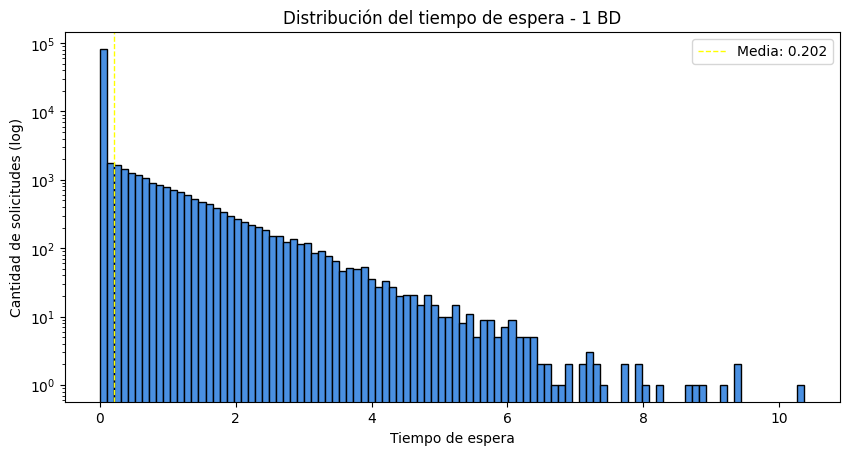

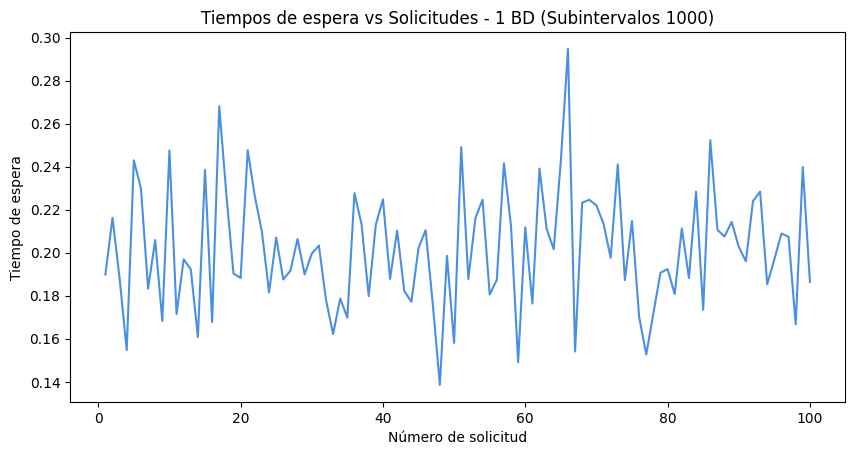

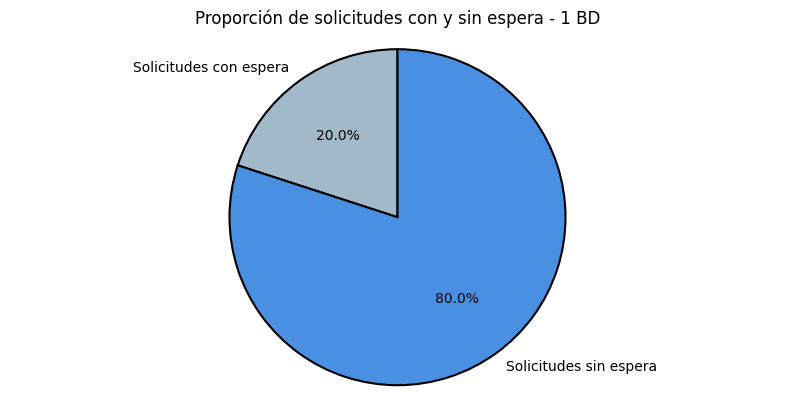

In [10]:
# Simulacion de una sola base
mu_demora = 0.8
estadisticas = simular_una_base(mu_demora)
estadisticas.histograma_tiempos_espera("Distribución del tiempo de espera - 1 BD")
estadisticas.grafico_tiempo_espera_vs_solicitudes("Tiempos de espera vs Solicitudes - 1 BD (Subintervalos 1000)", subintervalos=1_000)
estadisticas.grafico_proporcion_solicitudes_sin_esperar("Proporción de solicitudes con y sin espera - 1 BD")

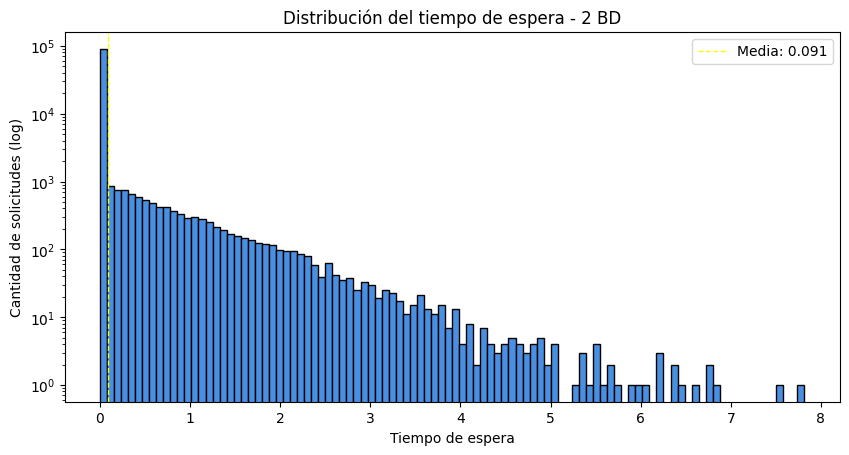

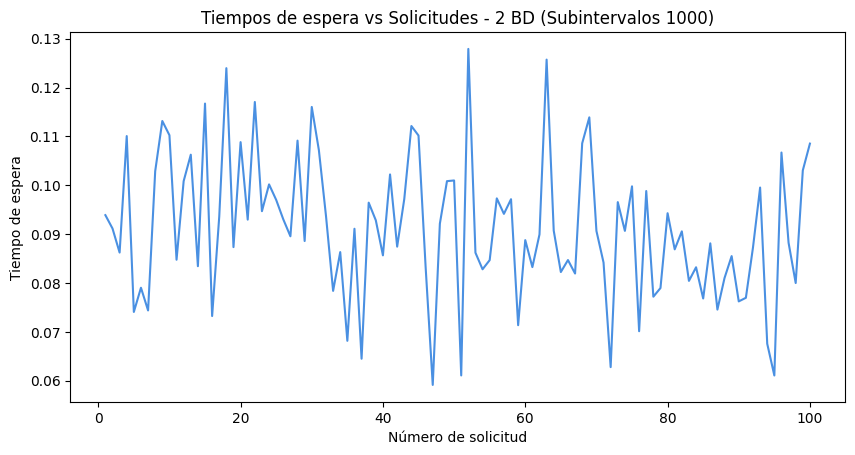

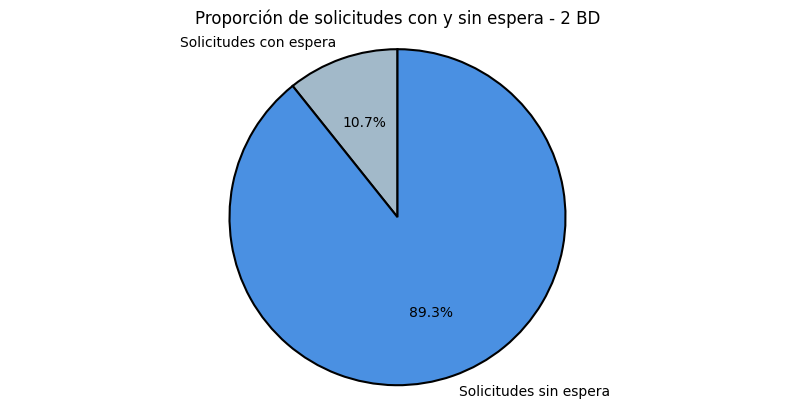

In [11]:
# Simulacion de dos bases
mu_demora_1 = 0.7
mu_demora_2 = 1
estadisticas = simular_dos_bases(mu_demora_1, mu_demora_2)
estadisticas.histograma_tiempos_espera("Distribución del tiempo de espera - 2 BD")
estadisticas.grafico_tiempo_espera_vs_solicitudes("Tiempos de espera vs Solicitudes - 2 BD (Subintervalos 1000)", subintervalos=1_000)
estadisticas.grafico_proporcion_solicitudes_sin_esperar("Proporción de solicitudes con y sin espera - 2 BD")

In [12]:
# Simulacion Grupo 5

LAMBDA_TIEMPO_INTERCONSULTA = 0.25
LAMBDA_TIEMPO_RESOLUCION = 1.25
NUMERO_DE_CONSULTAS = 100000

# Env y cola_de_consultas son objetos de simpy requeridos para la simulación. tiempos_de_arribo debe ser una lista
# vacía, de modo de poder almacenar la hora de arribo de cada consulta.
def recibir_consultas(env, cola_de_consultas, tiempos_de_arribo):
    # EL TIEMPO EMPIEZA A CORRER DESDE EL INSTANTE CERO
    instante_actual = 0
    numero_de_consulta = 1

    for i in range(NUMERO_DE_CONSULTAS):
        tiempo_en_llegar_consulta = random.expovariate(lambd=LAMBDA_TIEMPO_INTERCONSULTA)
        instante_actual += tiempo_en_llegar_consulta

        yield env.timeout(tiempo_en_llegar_consulta)
        yield cola_de_consultas.put(i)
        tiempos_de_arribo.append(instante_actual)

        numero_de_consulta += 1

# env y cola_de_consultas son objetos de simpy requeridos para la simulación. tiempos_de_arribo debe ser la lista
# usada para la función anterior (internamente se usa para calcular los tiempos de espera en cola en base a la
# diferencia entre la hora actual y la hora de arribo de una consulta). tiempos_de_resolucion y
# tiempos_de_espera_en_cola deben ser listas vacías (de modo de poder guardar información sobre lo que
# ocurre en la simulación).
def atender_consultas(env, cola_de_consultas, tiempos_de_resolucion, tiempos_de_arribo, tiempos_de_espera_en_cola):
    consultas_procesadas = 0

    while consultas_procesadas < NUMERO_DE_CONSULTAS:
        id_consulta = yield cola_de_consultas.get()
        tiempo_en_cola = env.now - tiempos_de_arribo[id_consulta]
        tiempos_de_espera_en_cola.append(tiempo_en_cola)
        tiempo_de_resolucion = random.expovariate(lambd=LAMBDA_TIEMPO_RESOLUCION)

        yield env.timeout(tiempo_de_resolucion)
        tiempos_de_resolucion.append(tiempo_de_resolucion)
        consultas_procesadas += 1


#Listas usadas para el calculo dde métricas.
tiempos_de_arribo = []
tiempos_de_resolucion = []
tiempos_de_espera_en_cola = []

env = simpy.Environment()
cola = simpy.Store(env)

env.process(recibir_consultas(env, cola, tiempos_de_arribo))
env.process(atender_consultas(env, cola, tiempos_de_resolucion, tiempos_de_arribo, tiempos_de_espera_en_cola))
env.run()

print("----------------------------------MÉTRICAS----------------------------------")
print("Cantidad que consultas que llegaron a la base de datos: ", len(tiempos_de_arribo))
print("Cantidad de consultas resueltas por la base de datos: ", len(tiempos_de_resolucion))
print("Tiempo promedio de espera en cola: ", numpy.mean(tiempos_de_espera_en_cola))
print("Porcentaje de solicitudes atendidas sin espera:", (tiempos_de_espera_en_cola.count(0)*100)/NUMERO_DE_CONSULTAS)
print("----------------------------------------------------------------------------")

----------------------------------MÉTRICAS----------------------------------
Cantidad que consultas que llegaron a la base de datos:  100000
Cantidad de consultas resueltas por la base de datos:  100000
Tiempo promedio de espera en cola:  0.20066332568234654
Porcentaje de solicitudes atendidas sin espera: 80.049
----------------------------------------------------------------------------


In [13]:
def histograma_tiempos_espera(titulo, num_intervalos=100):
    media_espera = numpy.mean(tiempos_de_espera_en_cola)

    plt.figure().set_figwidth(10)
    barra_color = '#4A90E2'
    linea_color = 'yellow'
    plt.hist(tiempos_de_espera_en_cola, bins=num_intervalos, edgecolor='black', color=barra_color, log=True)
    plt.axvline(media_espera, color=linea_color, linestyle='dashed', linewidth=1, label=f'Media: {media_espera:.3f}')
    plt.legend()
    plt.title(titulo)
    plt.xlabel("Tiempo de espera")
    plt.ylabel("Cantidad de solicitudes (log)")
    plt.show()

def grafico_tiempo_espera_vs_solicitudes(titulo, subintervalos=None):
    plt.figure().set_figwidth(10)


    if subintervalos is None:
        plt.plot([i for i in range(1, NUMERO_DE_CONSULTAS + 1)], tiempos_de_espera_en_cola, color='#4A90E2')
    else:
        historial_tiempos_espera = []
        for i in range(0, 100_000, subintervalos):
            sub_tiempo_medio = numpy.mean(tiempos_de_espera_en_cola[i : i + subintervalos])
            historial_tiempos_espera.append(sub_tiempo_medio)
        plt.plot([i for i in range(1, len(historial_tiempos_espera) + 1)], historial_tiempos_espera, color='#4A90E2')
    

    
    plt.title(titulo)
    plt.xlabel("Número de solicitud")
    plt.ylabel("Tiempo de espera")
    plt.show()

def grafico_proporcion_solicitudes_sin_esperar(titulo):
    proporcion = ((tiempos_de_espera_en_cola.count(0))/NUMERO_DE_CONSULTAS)
    sizes = [1 - proporcion, proporcion]
    labels = ['Solicitudes con espera', 'Solicitudes sin espera']

    colores = ['#A2B9C9', '#4A90E2']
    plt.figure().set_figwidth(10)
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colores,
                                       wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    plt.title(titulo)
    plt.axis('equal')
    plt.show()

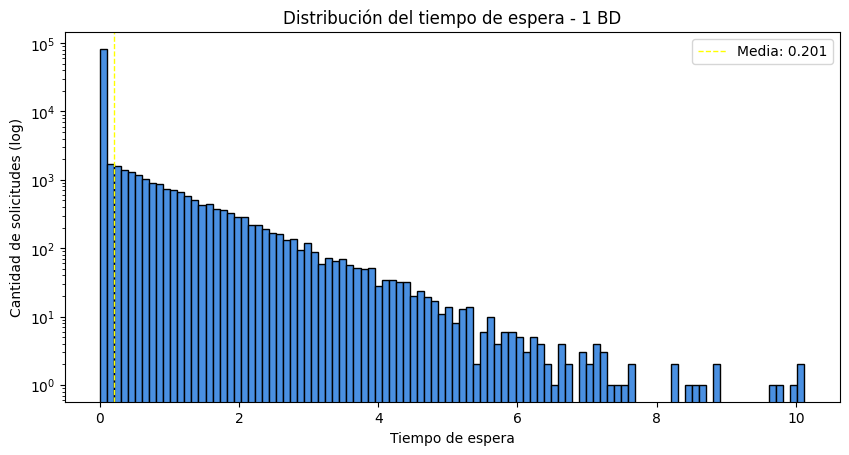

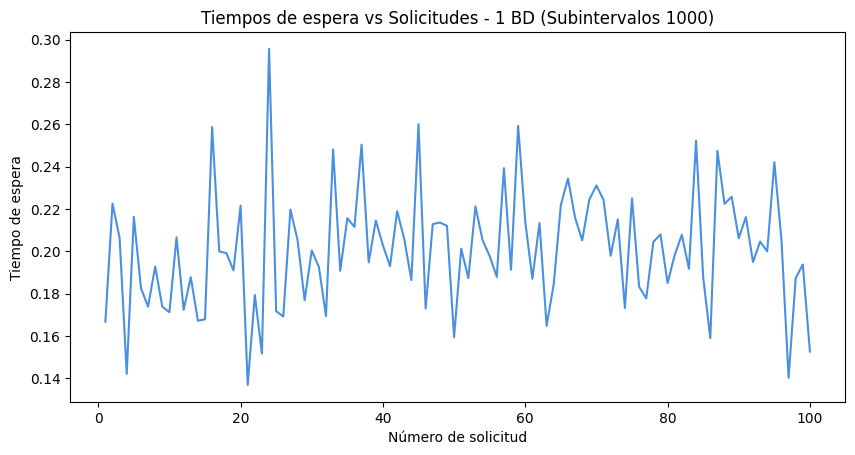

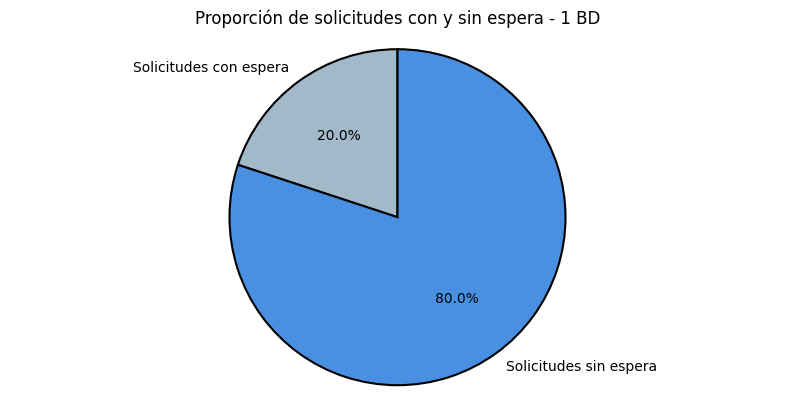

In [14]:
histograma_tiempos_espera("Distribución del tiempo de espera - 1 BD")
grafico_tiempo_espera_vs_solicitudes("Tiempos de espera vs Solicitudes - 1 BD (Subintervalos 1000)", 1_000)
grafico_proporcion_solicitudes_sin_esperar("Proporción de solicitudes con y sin espera - 1 BD")